In [1]:
%pylab inline

import numpy as np
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# Face recognition

The goal of this seminar is to build two simple (anv very similar) face recognition pipelines using **`scikit-learn`** package. Overall, we'd like to explore different representations and see which one works better. 

Создание двух простых pipeline для распознавания лиц трубопроводов с использованием scikit пакета. 
Исследовать различные представления и посмотреть, какой из них работает лучше.

## Prepare dataset

In [2]:
import scipy.io

image_h, image_w = 32, 32

data = scipy.io.loadmat('faces_data.mat') ##загрузили данные

X_train = data['train_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_train = data['train_labels'] - 1

X_test = data['test_faces'].reshape((image_w, image_h, -1)).transpose((2, 1, 0)).reshape((-1, image_h * image_w))
y_test = data['test_labels'] - 1

n_features = X_train.shape[1]

n_train = len(y_train)
n_test = len(y_test)
n_classes = len(np.unique(y_train))

print('Dataset loaded.')
print('  Image size        : {}x{}'.format(image_h, image_w))
print('  Train images      : {}'.format(n_train))
print('  Test images       : {}'.format(n_test))
print('  Number of classes : {}'.format(n_classes))

Dataset loaded.
  Image size        : 32x32
  Train images      : 280
  Test images       : 120
  Number of classes : 40


Now we are going to plot some samples from the dataset using the provided helper function.

Строим сэмплы из набора данных с помощью вспомогательной функции.

In [3]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='nearest')
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

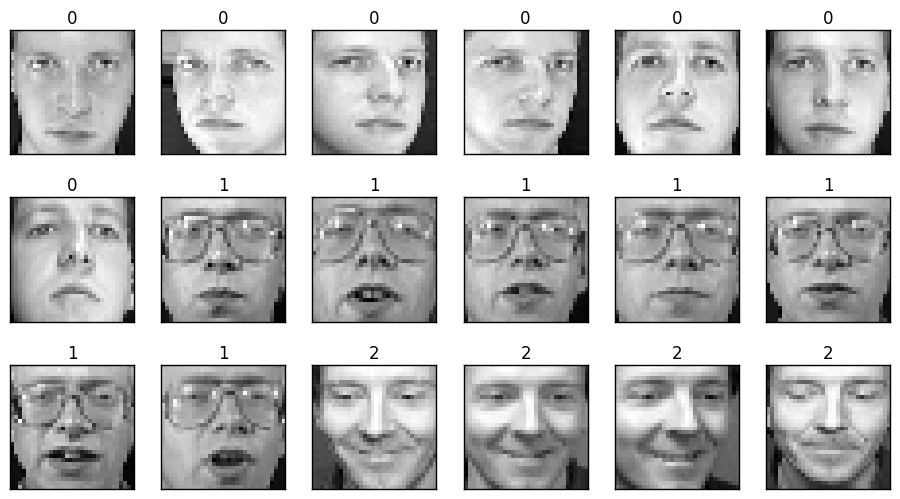

In [4]:
titles = [str(y[0]) for y in y_train]

plot_gallery(X_train, titles, image_h, image_w)

## Nearest Neighbour baseline - ближайший сосед

The simplest way to do face recognition is to treat raw pixels as features and perform **Nearest Neighbor Search** in the Euclidean space. Let's use **`KNeighborsClassifier`** class.

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Use KNeighborsClassifier to calculate test score for the Nearest Neighbour classifier.

knn = KNeighborsClassifier()
knn.fit(X_train, y_train.ravel()) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform')

knn.predict(X_test)
test_score = knn.score(X_test, y_test)
print('Test score: {}'.format(test_score))

Test score: 0.7833333333333333


Test score: 0.7833333333333333
Not very imperssive, is it?

## Eigenfaces

All the dirty work will be done by the scikit-learn package. First we need to learn a dictionary of codewords. For that we preprocess the training set by making each face normalized (zero mean and unit variance)..

In [18]:
# Populate variable 'X_train_processed' with samples each of which has zero mean and unit variance.
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_train_processed = scaler.fit_transform(X_train)          
X_test_processed = scaler.transform(X_test)                               

#http://scikit-learn.org/stable/modules/preprocessing.html

C:\Users\veron\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\veron\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\veron\Anaconda3\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Now we are going to apply **PCA** to obtain a dictionary of codewords. **`RamdomizedPCA`** class is what we need.

Анализ главных компонент. снижение размерности с помощью сингулярного разложения данных в пространстве меньшей размерности.

In [19]:
from sklearn.decomposition import RandomizedPCA

n_components = 64

# Populate 'pca' with a trained instance of RamdomizedPCA.
pca = RandomizedPCA(n_components)

We plot a bunch of principal components.

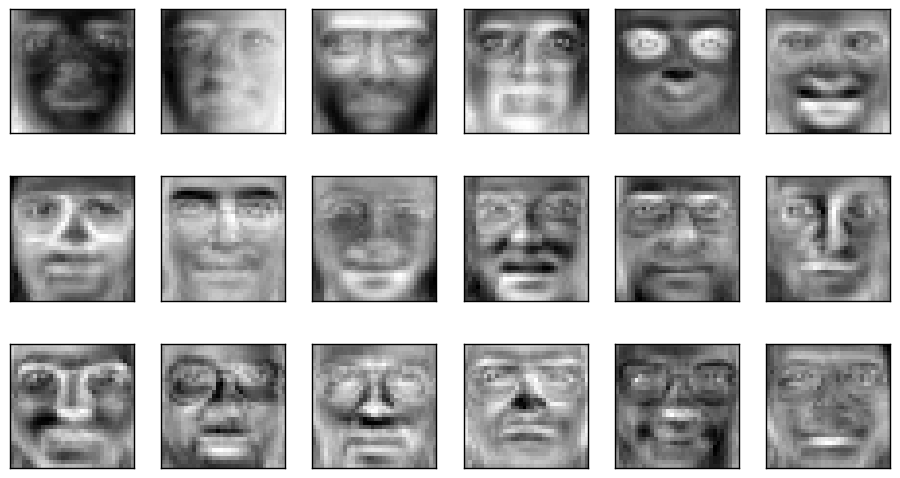

In [20]:
# Visualize principal components.
pca.fit(X_train_processed)  
plot_gallery(pca.components_, [""] * pca.components_.shape[0], 32, 32)

This time we don't have any restriction on number of non-zero coefficients in the vector decomposition, so the codes are not sparse anymore:

In [21]:
# Transform training data and plot decomposition coefficients.

pca.components_.reshape((n_components, image_h, image_w))

X_train_pca = pca.transform(X_train_processed)
X_test_pca = pca.transform(X_test_processed)

Train an SVM and apply it to the encoded test data.

In [25]:
# Populate 'test_score' with test accuracy of an SVM classifier.
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_pca, y_train.ravel()) 

test_score = clf.score(X_test_pca, y_test.ravel())
print('Test score: {}'.format(test_score))

Test score: 0.6666666666666666


Test score: 0.6666666666666666

How many components are sufficient to reach the same accuracy level?

Max accuracy: 0.6583333333333333


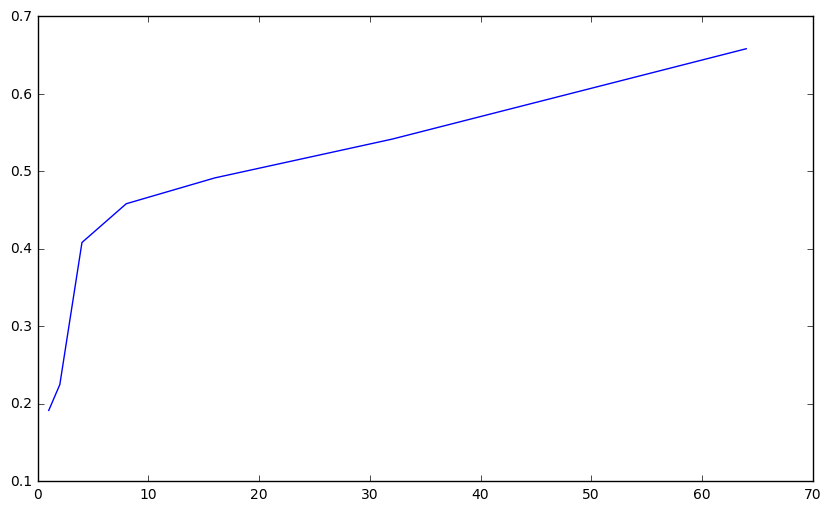

In [26]:
n_components = [1, 2, 4, 8, 16, 32, 64]
accuracy = []

# Try different numbers of components and populate 'accuracy' list.

for i in range(len(n_components)):
    pca = RandomizedPCA(n_components[i])
    pca.fit(X_train_processed)
    
    X_train_pca = pca.transform(X_train_processed)
    X_test_pca = pca.transform(X_test_processed)
    
    clf.fit(X_train_pca, y_train.ravel()) 
    accuracy.append(clf.score(X_test_pca, y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracy)

print('Max accuracy: {}'.format(max(accuracy)))